In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.transform import probabilistic_hough_line
from mpl_toolkits.mplot3d import Axes3D
import math
import cv2

In [ ]:
neurons = 100
x, y = np.linspace(0,neurons,neurons), np.linspace(0,neurons,neurons)
X, Y = np.meshgrid(x,y)

xo, yo = neurons/2, neurons/2
theta = 0.5 * np.arctan2(Y-yo, X-xo)

Z = np.exp(1j * 2 *theta)
noise_std = np.radians(5)
Z *= np.exp(1j * 2 *np.random.normal(0, noise_std, Z.shape))

Z_real = gaussian_filter(Z.real, sigma = 1)
Z_imag = gaussian_filter(Z.imag, sigma = 1)
Z_field = Z_real + 1j * Z_imag



In [ ]:

preferred_orientations = np.angle(Z_field) / 2


In [ ]:
num_stimuli = 100
R0 = 0
kappa = 3

theta_grid = np.linspace(0, np.pi , num_stimuli, endpoint = False)
preferred_theta = np.pi/4
kappa_prior = 5.0
prior = np.exp(kappa_prior * np.cos(2 * (theta_grid - preferred_theta)))
prior /= prior.sum()

stimulus_orientations = np.random.choice(
    theta_grid,
    size=num_stimuli,
    p=prior
)


distance = np.sqrt((X-xo)**2 + (Y-yo)**2)
runs = 1
FI_runs = []

for run in range(runs):

  FI_total = np.zeros_like(preferred_orientations)

  for theta_stim in stimulus_orientations:
    R = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - theta_stim)) - 1))
    dr_dtheta = -2 * kappa * np.sin(2*(preferred_orientations - theta_stim)) * R
    FI = (dr_dtheta**2) / (R + 1e-12)
    FI_total += FI

  FI_avg = FI_total / num_stimuli


  FI_runs.append(FI_avg)

FI_runs = np.array(FI_runs)



In [ ]:
print(FI_avg.shape)
print(FI_runs.shape)
print(FI_total.shape)
print(np.max(distance))

(100, 100)
(1, 100, 100)
(100, 100)
70.71067811865476


In [ ]:
FI_mean = FI_runs.mean(axis = 0)
FI_std = FI_runs.std(axis = 0)



/tmp/ipython-input-1889298044.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-1889298044.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


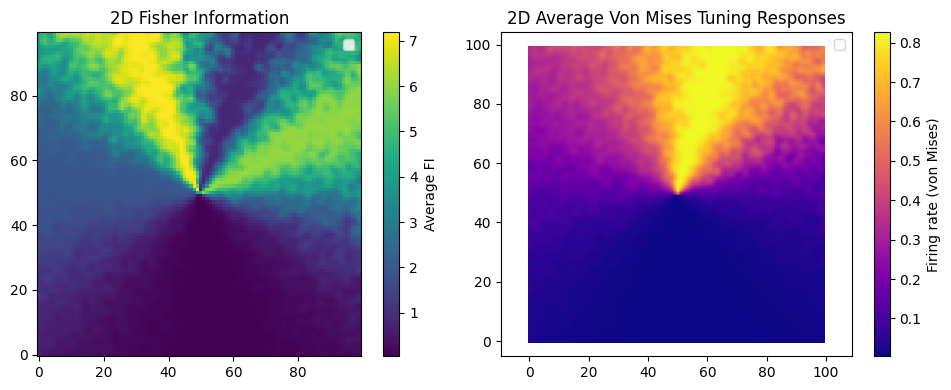

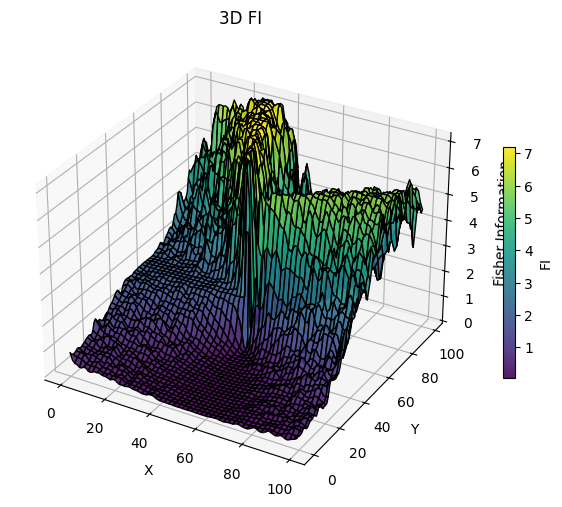

In [ ]:
R_maps = []
for ori in stimulus_orientations:
    current_R_map = R0 + np.exp(kappa * (np.cos(2*(preferred_orientations - ori)) - 1))
    R_maps.append(current_R_map)
R_map = np.mean(R_maps, axis=0)

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(FI_mean, cmap='viridis', origin='lower')
# plt.scatter([xo], [yo], color='red', s=50, label='Pinwheel Center')
plt.colorbar(label='Average FI')
plt.title('2D Fisher Information')


plt.subplot(1,2,2)
plt.imshow(R_map, cmap='plasma', origin='lower')
plt.colorbar(label='Firing rate (von Mises)')
plt.title('2D Average Von Mises Tuning Responses')
plt.axis('equal')
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
X_grid, Y_grid = np.meshgrid(np.arange(neurons), np.arange(neurons))
surf = ax.plot_surface(X_grid, Y_grid, FI_mean, cmap='viridis', edgecolor='k', alpha=0.9)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Fisher Information')
ax.set_title('3D FI')
fig.colorbar(surf, ax=ax, shrink=0.5, label='FI')
plt.show()